In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
from platform import python_version

In [10]:
print('Python version:', python_version())
print('Matplotlib version:', matplotlib.__version__)
print('cartopy version:', cartopy.__version__)
print('NumPy version:', np.__version__)
print('Xarray version:', xr.__version__)
print('NumPy version:', np.__version__)

Python version: 3.7.7
Matplotlib version: 3.1.3
cartopy version: 0.17.0
NumPy version: 1.18.1
Xarray version: 0.15.1
NumPy version: 1.18.1


In [54]:
def delta_change(matrix,cutoff=75): 
    '''
    It calculates the edges or unnatural points(lines) in the data (some noise is also detected in the process)
    
    Parameters
    ----------
    matrix : numpy.ndarray
        The data for which the edges are to be detected
        
    cutoff : int
        The percentile cutoff under which the data is to be ignored (not considered) for edge detection
        
    Returns
    -------
    delta_array : numpy.ndarray
        This raster includes the original data combined with smoothened out points replaced using target data
        adjusted for the gama value
    '''
    row,col = matrix.shape
    delta_array = np.arange(row*col).reshape(row,col)
    delta_array = delta_array.astype(float)
    delta_array[:] = np.nan
    datain = matrix.copy()
    datain[datain<np.nanpercentile(datain,cutoff)] = np.nan
    for i in range(0,(row-1)):
        for j in range(0,(col-1)):
            top_cell_change = abs(((datain[i-1][j] - datain[i][j])/datain[i][j])*100)
            top_left_cell_change = abs(((datain[i-1][j-1] - datain[i][j])/datain[i][j])*100)
            top_right_cell_change = abs(((datain[i-1][j+1] - datain[i][j])/datain[i][j])*100)
            bottom_cell_change = abs(((datain[i+1][j] - datain[i][j])/datain[i][j])*100)
            bottom_left_cell_change = abs(((datain[i+1][j-1] - datain[i][j])/datain[i][j])*100)
            bottom_right_cell_change = abs(((datain[i+1][j+1] - datain[i][j])/datain[i][j])*100)
            left_cell_change = abs(((datain[i][j-1] - datain[i][j])/datain[i][j])*100)
            top_cell_change = abs(((datain[i][j+1] - datain[i][j])/datain[i][j])*100)
            delta_array[i][j] = np.nanmax([top_cell_change,top_right_cell_change,top_left_cell_change,
                            bottom_cell_change,bottom_right_cell_change,bottom_left_cell_change,left_cell_change,top_cell_change])

    delta_array[delta_array<np.nanpercentile(delta_array,cutoff)] = np.nan 
    
    return delta_array

def count_pixels(data_xarray):
    '''
    Count the number of datapoints for the raster
    
    Parameters
    ----------
    data_xarray : xarray.DataArray
        A raster of xarray.DataArray type for which datapoints are to be counted
        
    Returns
    -------
    count : int
        This total number of Non NAN datapoints in the raster
        
    '''
    count = np.count_nonzero(~np.isnan(data_xarray.values))
    return count


def interpolate_data(original_data,target_data,gama=3):
    '''
    This function interpolates the data for pixels which are identified as edges or target points. 
    It takes a 5x5 window around with target pixel as center and fills the target point in original dataset with 
    mean of all values within the window.
    
    Parameters
    ----------
    original_data : numpy.ndarray
        A raster of original raw data which needs to be smoothened at target points 
    
    target_data : numpy.ndarray
        A raster of identified edge pixels which needs to be smoothened in the original data 
        
    gama : int (range 1-3)
        The number of pixels around the target pixel that needs to be smoothened out
        
    Returns
    -------
    new_array : numpy.ndarray
        This raster includes the original data combined with smoothened out points replaced using target data
        adjusted for the gama value
    '''
    row,col = original_data.shape
    new_array = np.arange(row*col).reshape(row,col)
    new_array = new_array.astype(float)
    new_array[:] = np.nan
    if(gama==1):
        for i in range(1,(row-1)):
            for j in range(1,(col-1)):
                if((np.isnan(target_data[i][j])) or (~np.isnan(original_data[i][j]))):
                    if((~np.isnan(new_array[i][j]))):
                        continue
                    else:
                        new_array[i][j]=original_data[i][j]
                        
                if((~np.isnan(target_data[i][j]))): # performing interpolation for the targeted cells
                    
                    new_array[i][j]= np.nanmean(original_data[i-5:i+5,j-5:j+5])
                
    if(gama==2):
        for i in range(2,(row-2)):
            for j in range(2,(col-2)):
                if((np.isnan(target_data[i][j])) or (~np.isnan(original_data[i][j]))):
                    if((~np.isnan(new_array[i][j]))):
                        continue
                    else:
                        new_array[i][j]=original_data[i][j]
                        
                if((~np.isnan(target_data[i][j]))): # performing interpolation for the targeted cells
                    
                    new_array[i][j]= np.nanmean(original_data[i-5:i+5,j-5:j+5])
                    new_array[i+1][j]= np.nanmean(original_data[i+1-5:i+1+5,j-5:j+5])
                    new_array[i+1][j+1]= np.nanmean(original_data[i+1-5:i+1+5,j+1-5:j+1+5])
                    new_array[i+1][j-1]= np.nanmean(original_data[i+1-5:i+1+5,j-1-5:j-1+5])
                    new_array[i-1][j] = np.nanmean(original_data[i-1-5:i-1+5,j-5:j+5])
                    new_array[i-1][j+1] = np.nanmean(original_data[i-1-5:i-1+5,j+1-5:j+1+5])
                    new_array[i-1][j-1] = np.nanmean(original_data[i-1-5:i-1+5,j-1-5:j-1+5])
                    
    if(gama==3):
        for i in range(3,(row-3)):
            for j in range(3,(col-3)):
                if((np.isnan(target_data[i][j])) or (~np.isnan(original_data[i][j]))):
                    if((~np.isnan(new_array[i][j]))):
                        continue
                    else:
                        new_array[i][j]=original_data[i][j]
                        
                if((~np.isnan(target_data[i][j]))): # performing interpolation for the targeted cells
                    
                    new_array[i][j]= np.nanmean(original_data[i-5:i+5,j-5:j+5])
                    new_array[i][j+1]= np.nanmean(original_data[i-5:i+5,j+1-5:j+1+5])
                    new_array[i][j-1]= np.nanmean(original_data[i-5:i+5,j-1-5:j-1+5])
                    new_array[i+1][j]= np.nanmean(original_data[i+1-5:i+1+5,j-5:j+5])
                    new_array[i+1][j+1]= np.nanmean(original_data[i+1-5:i+1+5,j+1-5:j+1+5])
                    new_array[i+1][j-1]= np.nanmean(original_data[i+1-5:i+1+5,j-1-5:j-1+5])
                    new_array[i+2][j]= np.nanmean(original_data[i+2-5:i+2+5,j-5:j+5])
                    new_array[i+2][j+1]= np.nanmean(original_data[i+2-5:i+2+5,j+1-5:j+1+5])
                    new_array[i+2][j+2]= np.nanmean(original_data[i+2-5:i+2+5,j+2-5:j+2+5])
                    new_array[i+2][j-1]= np.nanmean(original_data[i+2-5:i+2+5,j-1-5:j-1+5])
                    new_array[i+2][j-2]= np.nanmean(original_data[i+2-5:i+2+5,j-2-5:j-2+5])
                    
                    new_array[i-2][j]= np.nanmean(original_data[i-2-5:i-2+5,j-5:j+5])
                    new_array[i-2][j+1]= np.nanmean(original_data[i-2-5:i-2+5,j+1-5:j+1+5])
                    new_array[i-2][j+2]= np.nanmean(original_data[i-2-5:i-2+5,j+2-5:j+2+5])
                    new_array[i-2][j-1]= np.nanmean(original_data[i-2-5:i-2+5,j-1-5:j-1+5])
                    new_array[i-2][j-2]= np.nanmean(original_data[i-2-5:i-2+5,j-2-5:j-2+5])
                    
                    new_array[i-1][j+2]= np.nanmean(original_data[i-1-5:i-1+5,j+2-5:j+2+5])
                    new_array[i][j+2]= np.nanmean(original_data[i-5:i+5,j+2-5:j+2+5])
                    new_array[i+1][j+2]= np.nanmean(original_data[i+1-5:i+1+5,j+2-5:j+2+5])
                    
                    new_array[i-1][j-2]= np.nanmean(original_data[i-1-5:i-1+5,j-2-5:j-2+5])
                    new_array[i][j-2]= np.nanmean(original_data[i-5:i+5,j-2-5:j-2+5])
                    new_array[i+1][j-2]= np.nanmean(original_data[i+1-5:i+1+5,j-2-5:j-2+5])
                    
                    new_array[i-1][j] = np.nanmean(original_data[i-1-5:i-1+5,j-5:j+5])
                    new_array[i-1][j+1] = np.nanmean(original_data[i-1-5:i-1+5,j+1-5:j+1+5])
                    new_array[i-1][j-1] = np.nanmean(original_data[i-1-5:i-1+5,j-1-5:j-1+5])
                    
    return new_array

def delta_call(raster_input,iterations=2,cutoff1=70,cutoff2=70):
    '''
    This function calculates the target matrix and can adjust the number of calls to the delta_change()
    
    Parameters
    ----------
    raster_input : numpy.ndarray
        The data for which the edges are to be detected
        
    iterations : int (range= 1-2)
        The number of iterations for which the the delta_change() is to be called 
        
    cutoff1 : int
        The cutoff which needs to be applied for first call
    
    cutoff2 : int
        The cutoff which needs to be applied for second call
        
    Returns
    -------
    roc : numpy.ndarray
        The raster obtained after calling the delta_change() n number of times 
    '''
    if (iterations==2):
        roc_init = delta_change(raster_input,cutoff1)
        roc = delta_change(roc_init,cutoff2)
    if (iterations==1):
        roc = delta_change(raster_input,cutoff1)
    return roc

def plot_figure(data_xarray,shapefile_feature,title,save_file=False,colorbar=True,path_out='./',fileout_name='output'):
    '''
    This function plots the AOD data with the US map (shapefile data)
    
    Parameters
    ----------
    data_xarray : xarray.DataArray
        A raster of xarray.DataArray type that needs to be plotted with lat and lon as coordinates
    
    shapefile_feature : cartopy.feature.ShapelyFeature
        The US border map shapefile to be plotted
    
    title : String
        The title of the plot
        
    path_out : String
        The path for image output (only with forward slash with a slash in the end)
    
    fileout_name : String
        The name of the output image file
        
    save_file : Bool
        To check if image is to be saved or not
        
    colorbar : Bool
        To check if image is to be plotted with colorbar or not
    '''
    fig,ax = plt.subplots(figsize=(20,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-104.1,-80.6,29.7,41.8],crs=None)
    col = plt.get_cmap('jet')
    #col.set_under('#000082')
    #col.set_over('#820000')
    #kk = darray.plot()
    if(colorbar==False):
        kk = data_xarray.plot(ax=ax,cmap=col,extend='both')
        cbar = kk.colorbar
        cbar.remove()
    #cbar.ax.get_yaxis().set_ticks([0.00001,0.00003,0.00005,0.00007,0.00009])
    if(colorbar==True):
        kk = data_xarray.plot(ax=ax,cmap=col,extend='both')
        cbar = kk.colorbar
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('Aerosol Optical Depth #', rotation=90)
    plt.title(title)
    #lp=lp+1,
    ax.add_feature(shape_feature1)
    if(save_file== True):
        plt.savefig(path_out+fileout_name+'.png', dpi=300)
    plt.tight_layout()
    plt.show()

def convert_raster(input_raster):
    '''
    This function plots the AOD data with the US map (shapefile data)
    
    Parameters
    ----------
    data_xarray : xarray.Dataset
        A raster of xarray.Dataset type that is to be converted to numpy array with coordinates
        
    Returns
    -------
    aod : numpy.ndarray
        The raster values of the orginal raster after removing the np.nan values
    
    lati : numpy.ndarray
        The latitude values of the raster
    
    long : numpy.ndarray
        The longitude values of the raster
    '''
    aod = DS2.AOD_550.values
    aod[aod<=0] = np.nan
    lat = input_raster.lat.values
    lon = input_raster.lon.values
    lat1 = np.transpose(lat)
    lati = lat1[1][:]
    long = lon[1][:]
    return aod,lati,long

In [24]:
import warnings
warnings.filterwarnings('ignore')
path_in = './Data/'

shape_feature1 = ShapelyFeature(Reader('./Data/cb_2018_us_state_20m.shp').geometries(),ccrs.PlateCarree(),
                                facecolor='none',edgecolor='black')


### Testing 10 sept 2021 file

In [60]:
filenm = 'MCD19A2.A2021253.h10v05.006.2021255045255.hdf_out.nc' # 10 sept 2021 file

DS2 = xr.open_dataset(path_in+filenm)
aod,lati,long = convert_raster(DS2)

target_data = delta_call(aod)
smoothed_data = interpolate_data(aod,target_data,gama=3)
rawtile = xr.DataArray(aod,coords=[lati,long],dims=['lat','lon'])
smoothtile = xr.DataArray(smoothed_data,coords=[lati,long],dims=['lat','lon'])
targettile = xr.DataArray(target_data,coords=[lati,long],dims=['lat','lon'])

In [61]:
print('Raw data valid pixels=' ,count_pixels(rawtile))
print('Target data valid pixels= ',count_pixels(targettile))

Raw data valid pixels= 1146846
Target data valid pixels=  8959


Raw data Plot


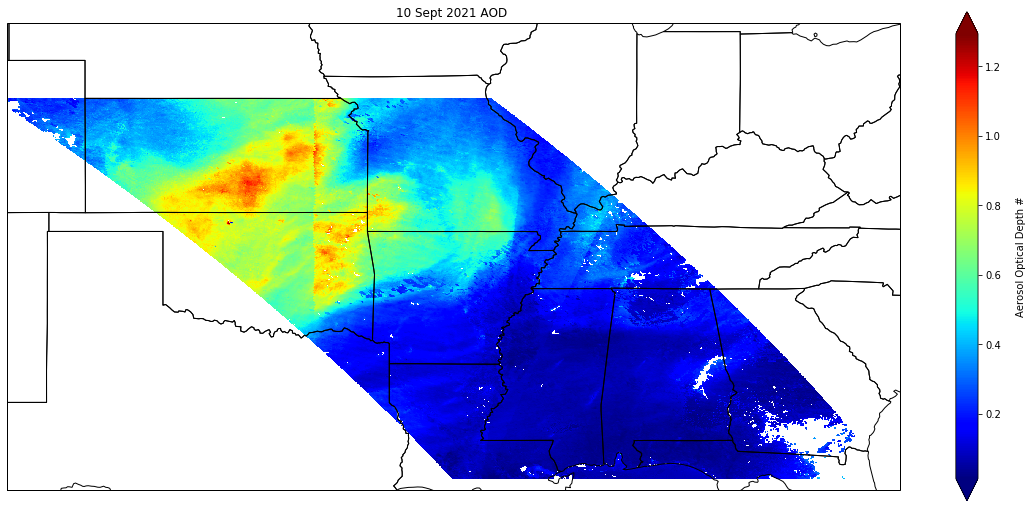


 Target points Plot


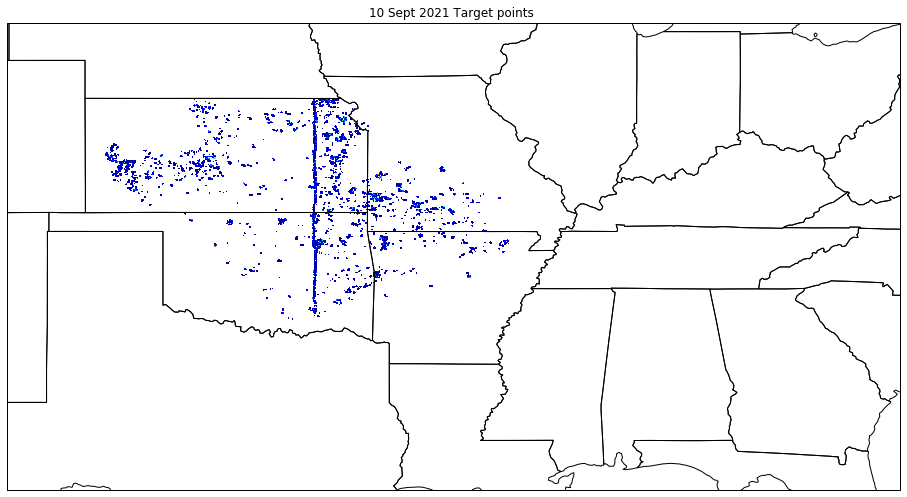


 smoothened data Plot


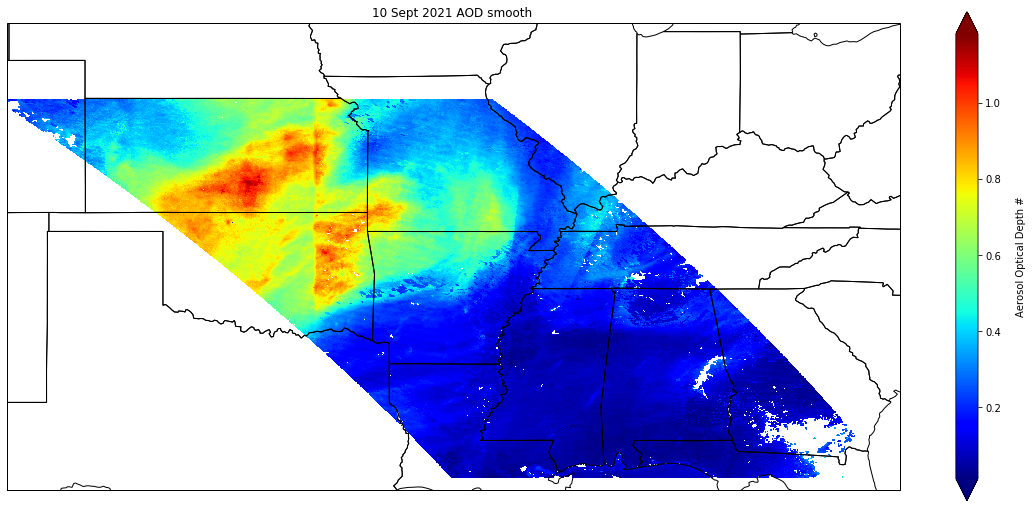

In [62]:
%matplotlib inline 
print('Raw data Plot')
plot_figure(rawtile,shape_feature1,title='10 Sept 2021 AOD ',colorbar=True)
print('\n Target points Plot')
plot_figure(targettile,shape_feature1,title='10 Sept 2021 Target points ',colorbar=False)
print('\n smoothened data Plot')
plot_figure(smoothtile,shape_feature1,title='10 Sept 2021 AOD smooth ',colorbar=True)

### Testing 19 sept 2020 file

In [68]:
filenm = 'MCD19A2.A2020262.h10v05.006.2020281053802.hdf_out.nc' # 19 sept 2020 file

DS2 = xr.open_dataset(path_in+filenm)
aod,lati,long = convert_raster(DS2)

target_data = delta_call(aod)
smoothed_data = interpolate_data(aod,target_data,gama=3)
rawtile = xr.DataArray(aod,coords=[lati,long],dims=['lat','lon'])
smoothtile = xr.DataArray(smoothed_data,coords=[lati,long],dims=['lat','lon'])
targettile = xr.DataArray(target_data,coords=[lati,long],dims=['lat','lon'])

In [37]:
print('Raw data valid pixels=' ,count_pixels(rawtile))
print('Target data valid pixels= ',count_pixels(targettile))

Raw data valid pixels= 624063
Target data valid pixels=  4957


Raw data Plot


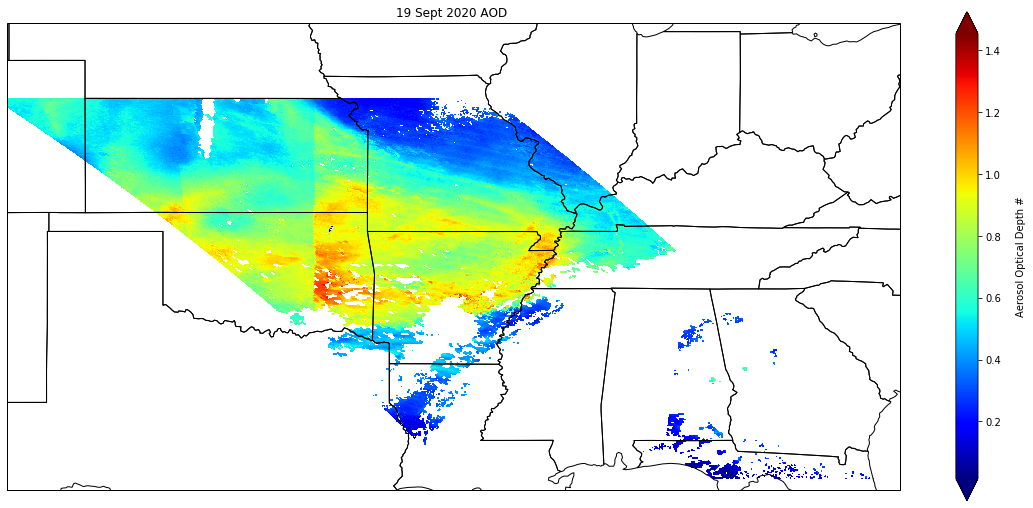


 Target points Plot


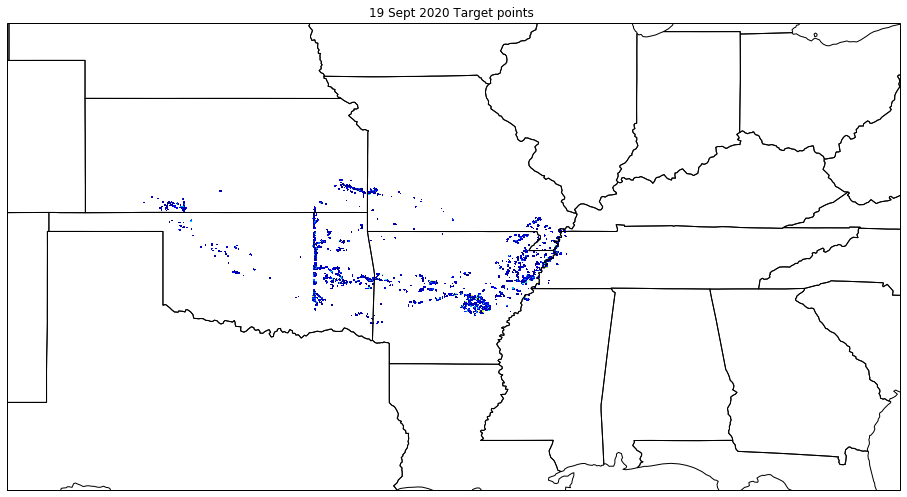


 smoothened data Plot


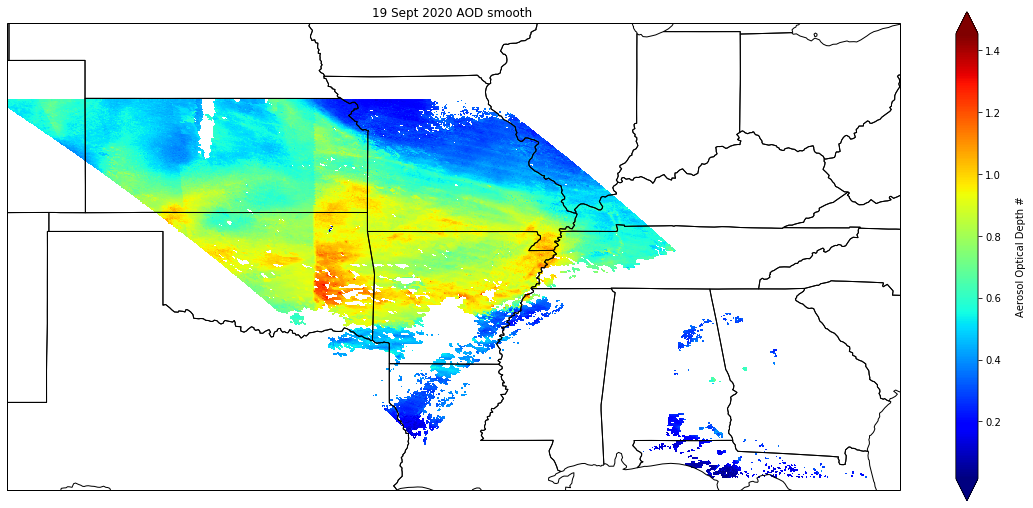

In [70]:
%matplotlib inline 
print('Raw data Plot')
plot_figure(rawtile,shape_feature1,title='19 Sept 2020 AOD ',colorbar=True)
print('\n Target points Plot')
plot_figure(targettile,shape_feature1,title='19 Sept 2020 Target points ',colorbar=False)
print('\n smoothened data Plot')
plot_figure(smoothtile,shape_feature1,title='19 Sept 2020 AOD smooth ',colorbar=True)

### Testing 11 sept 2021 file

In [66]:
filenm = 'MCD19A2.A2021254.h10v05.006.2021256055108.hdf_out.nc' # 11 sept 2021 file

DS2 = xr.open_dataset(path_in+filenm)
aod,lati,long = convert_raster(DS2)

target_data = delta_call(aod)
smoothed_data = interpolate_data(aod,target_data,gama=3)
rawtile = xr.DataArray(aod,coords=[lati,long],dims=['lat','lon'])
smoothtile = xr.DataArray(smoothed_data,coords=[lati,long],dims=['lat','lon'])
targettile = xr.DataArray(target_data,coords=[lati,long],dims=['lat','lon'])

In [58]:
print('Raw data valid pixels=' ,count_pixels(rawtile))
print('Target data valid pixels= ',count_pixels(targettile))

Raw data valid pixels= 971246
Target data valid pixels=  7656


Raw data Plot


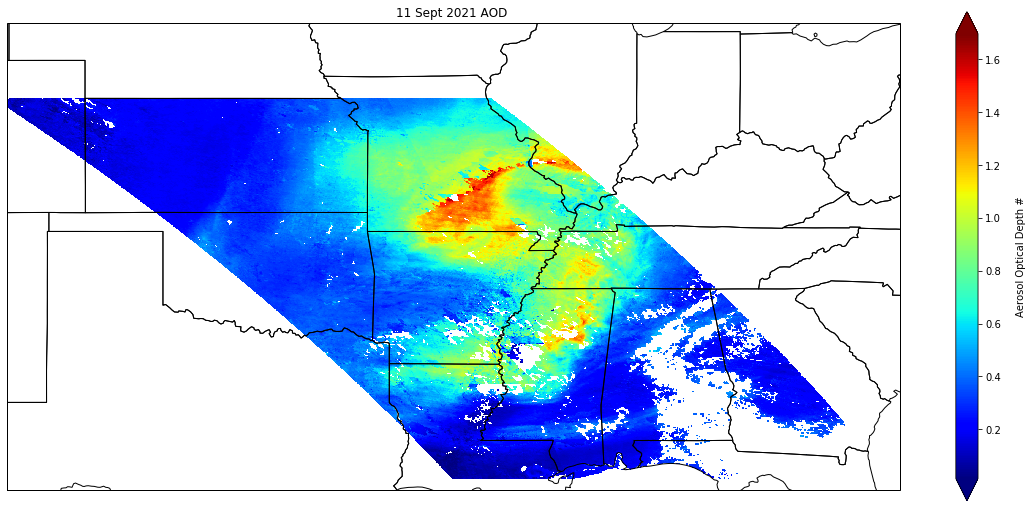


 Target points Plot


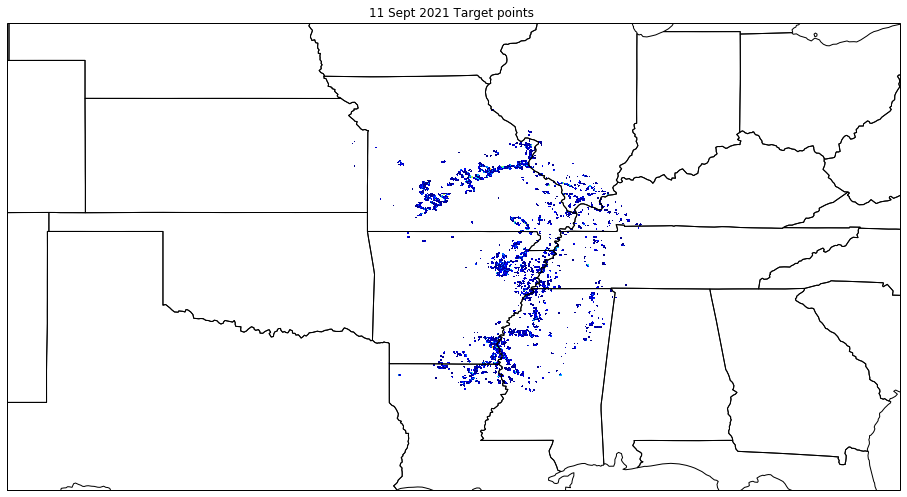


 smoothened data Plot


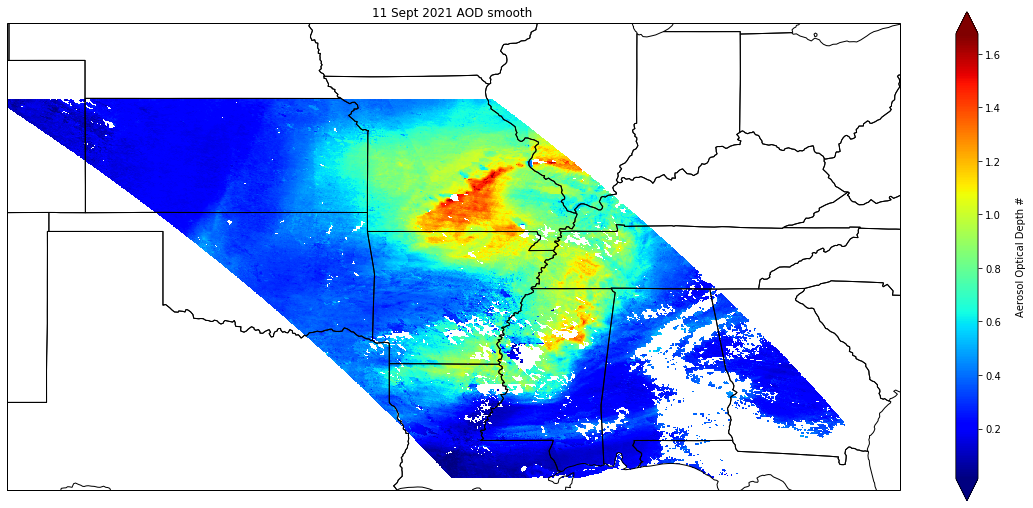

In [59]:
%matplotlib inline 
print('Raw data Plot')
plot_figure(rawtile,shape_feature1,title='11 Sept 2021 AOD ',colorbar=True)
print('\n Target points Plot')
plot_figure(targettile,shape_feature1,title='11 Sept 2021 Target points ',colorbar=False)
print('\n smoothened data Plot')
plot_figure(smoothtile,shape_feature1,title='11 Sept 2021 AOD smooth ',colorbar=True)